<a href="https://colab.research.google.com/github/gbuzzard/PnP-MACE/blob/master/demo/superres_mace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Overview:**

This demo illustrates the solution of a superresolution problem
using Mann iteration and the stacked operators $F$ and $G$.  The forward
model is a subsampling operation, and the prior agent is a
denoiser, with several different options.

First a clean image is subsampled, then white noise is added to
produce noisy data.  This is used to define a forward agent that
updates to better fit the data.

In a classical Bayesian approach, this update has the form $F(x)
= x + c A^T (y - Ax)$, for a constant c.  In some contexts, it's
useful to have a mismatched backprojector, which is equivalent to
replacing $A^T$ with an alternative matrix designed to promote
better or faster reconstruction.  As shown in a paper by Emma Reid (in preparation), this is equivalent to using the standard back projector but changing the prior.

This demo provides the ability to explore mismatched backprojectors by
changing the upsampling method used to define $A^T$.  It also
provides the ability to change the relative weight of data-fitting and
denoising by changing mu.

This demo uses parallel construction based on the MACE formulation and Mann
iterations, while superres_pnp.py uses the standard Plug and Play method.



--

Copyright (C) 2021 by Greg Buzzard <buzzard@purdue.edu>
All rights reserved.

Permission is hereby granted, free of charge, to any person obtaining a copy of this 
software and associated documentation files (the "Software"), to deal in the Software 
without restriction, including without limitation the rights to use, copy, modify, merge, 
publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons 
to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or 
substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING 
BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. 
IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, 
WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE 
SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [1]:
!pip install pnp_mace

from dotmap import DotMap
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import denoise_tv_chambolle

import pnp_mace as pnpm



     |████████████████████████████████| 8.4MB 5.5MB/s 
  Created wheel for pnp-mace: filename=pnp_mace-0.1.0b3-py2.py3-none-any.whl size=11472 sha256=2fd7d94f070a8ae3a12848a25e5c632a95a1b0a3e42bea1f181d82393c4b4652
  Stored in directory: /root/.cache/pip/wheels/0d/35/b6/67a027f718ddc0a4339cd21e45d135fcc5c3e5808a8ff2540d
Successfully built pnp-mace


**Load test image**

Read an image, then create noisy, subsampled data for use in a forward model.

In [2]:
img_path = ("https://raw.githubusercontent.com/bwohlberg/sporco/master/"
            "sporco/data/kodim23.png")
test_image = pnpm.load_img(img_path, convert_to_gray=True,
                            convert_to_float=True)  # create the image
test_image = np.asarray(Image.fromarray(test_image).crop((100, 100, 356, 312)))



Adjust image shape as needed to allow for up/down sampling.


In [3]:
factor = 4  # Downsampling factor
new_size = factor * np.floor(np.double(test_image.shape) / np.double(factor))
new_size = new_size.astype(int)
resized_image = Image.fromarray(test_image).crop((0, 0, new_size[1], new_size[0]))
resample = Image.NONE
ground_truth = np.asarray(resized_image)
clean_data = pnpm.downscale(ground_truth, factor, resample)



Create noisy downsampled image, then use this to generate an initial solution for MACE.  Then display some test images.  



In [4]:
noise_std = 0.05  # Noise standard deviation
seed = 0          # Seed for pseudorandom noise realization
noisy_data = pnpm.add_noise(clean_data, noise_std, seed)

init_image = pnpm.upscale(noisy_data, factor, Image.BICUBIC)



Display some test images.

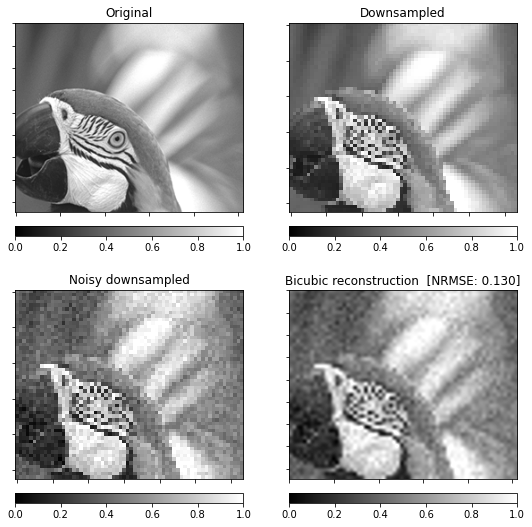

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
pnpm.display_image(ground_truth, title="Original", fig=fig, ax=ax[0, 0])
pnpm.display_image(clean_data, title="Downsampled", fig=fig, ax=ax[0, 1])
pnpm.display_image(noisy_data, title="Noisy downsampled", fig=fig,
                    ax=ax[1, 0])
pnpm.display_image_nrmse(init_image, ground_truth,
                          title="Bicubic reconstruction", fig=fig, ax=ax[1, 1])
fig.show()



Set up the forward agent. We'll use a linear prox map, so we need to
define A and AT.  In a true Bayesian approach, $A$ and $A^T$ are transposes of one another, but in the case of a mismatched back-projection, $A^T$ may be replaced by a matrix that is close to $A^T$.  In some cases, this can give better reconstruction quality and can be shown to be equivalent to changing the prior agent appropriately.  


In [6]:
downscale_type = Image.BICUBIC
upscale_type = Image.BICUBIC


def A(x):
    return pnpm.downscale(x, factor, downscale_type)


def AT(x):
    return pnpm.upscale(x, factor, upscale_type)


step_size = 0.1
forward_agent = pnpm.LinearProxForwardAgent(noisy_data, A, AT, step_size)


Set up the prior agent.  This is typically a denoiser, which in theory is used to denoise additive Gaussian noise, regardless of the characteristics of the noisy data.  In practice, the prior agent can greatly affect the reconstruction quality.  

In [7]:
# Set the denoiser for the prior agent
def denoiser(x, params):
    # denoised_x = denoise_tv_chambolle(x, weight=0.01)
    denoised_x = pnpm.bm3d_method(x, params)
    return denoised_x


prior_agent_method = denoiser

prior_params = DotMap()
prior_params.noise_std = noise_std

prior_agent = pnpm.PriorAgent(prior_agent_method, prior_params)

Compute and display one step of forward and prior agents for illustration purposes.

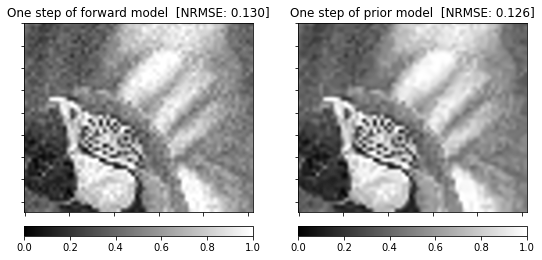

In [8]:
one_step_forward = forward_agent(np.asarray(init_image))
one_step_prior = prior_agent(np.asarray(init_image))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
pnpm.display_image_nrmse(one_step_forward, ground_truth,
                          title="One step of forward model", fig=fig, ax=ax[0])
pnpm.display_image_nrmse(one_step_prior, ground_truth,
                          title="One step of prior model", fig=fig, ax=ax[1])
fig.show()

Set up the equilibrium problem

In [9]:
mu0 = 0.5  # Forward agent weight
mu = [mu0, 1 - mu0]
rho = 0.5
num_iters = 20
keep_all_images = False

equil_params = DotMap()
equil_params.mu = mu
equil_params.rho = rho
equil_params.num_iters = num_iters
equil_params.keep_all_images = keep_all_images
equil_params.verbose = True

agents = [forward_agent, prior_agent]
equil_prob = pnpm.EquilibriumProblem(agents, pnpm.mann_iteration_mace,
                                      equil_params)

init_images = pnpm.stack_init_image(init_image, len(agents))

Compute the Mann iterations to approximate the MACE solution.

In [10]:
final_images, residuals, vectors, all_images = equil_prob.solve(init_images)
v_sum = mu[0] * vectors[0] + mu[1] * vectors[1]
i0 = Image.fromarray(final_images[0])

Starting Mann iterations
Finished iteration 1 of 20
Finished iteration 2 of 20
Finished iteration 3 of 20
Finished iteration 4 of 20
Finished iteration 5 of 20
Finished iteration 6 of 20
Finished iteration 7 of 20
Finished iteration 8 of 20
Finished iteration 9 of 20
Finished iteration 10 of 20
Finished iteration 11 of 20
Finished iteration 12 of 20
Finished iteration 13 of 20
Finished iteration 14 of 20
Finished iteration 15 of 20
Finished iteration 16 of 20
Finished iteration 17 of 20
Finished iteration 18 of 20
Finished iteration 19 of 20
Finished iteration 20 of 20


Display results.

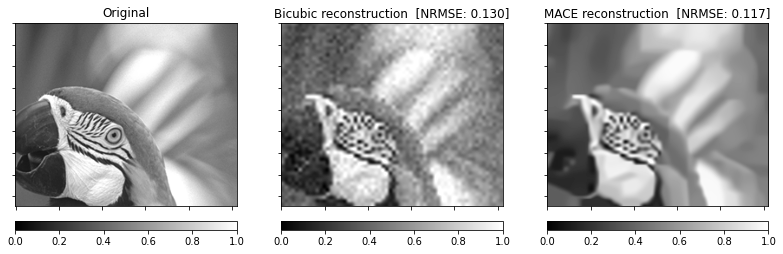

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(13.5, 5))
pnpm.display_image(ground_truth, title="Original", fig=fig, ax=ax[0])
pnpm.display_image_nrmse(init_image, ground_truth,
                          title="Bicubic reconstruction", fig=fig, ax=ax[1])
pnpm.display_image_nrmse(i0, ground_truth, title="MACE reconstruction",
                          fig=fig, ax=ax[2])
fig.show()
